In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
# general hyper parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.0001

In [112]:
# hyper parameters for the discriminator
d_input_size = 784 # 28 * 28
d_hidden_size = 50

In [113]:
# hyper parameters for the generator
latent_dim = 100
g_hidden_size = 50

In [138]:
# Load and normalize CIFAR10 dataset to [-1, 1]

#transform = transforms.Compose(
#    [transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


#trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [114]:
# Get the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)

# TODO test_dataset

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

# TODO test_loader

torch.Size([100, 1, 28, 28])


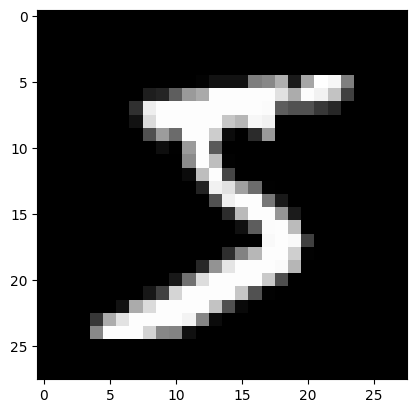

In [115]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
image = np.array(images[0], dtype="float")
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap="gray")
plt.show()

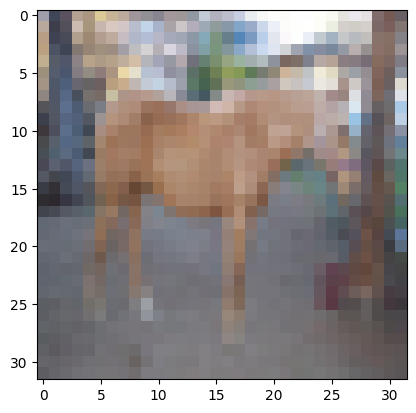

In [9]:
# Display one image as an example
dataiter = iter(trainloader)
images, labels = next(dataiter)
first_image = np.transpose(images[0], (1, 2, 0))
first_image = first_image / 2 + 0.5    # unnormalize

plt.imshow(first_image)

In [11]:
# Define the discriminator, returns a value between 0 and 1, a possibility.
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.sigmoid(out)
        return out

In [9]:
# Define the generator, returns a tensor with shape (3, 32, 32)
class Generator(nn.Module):
    def __init__(self, latent_dim_size, hidden_size):
        super().__init__()
        self.l1 = nn.Linear(latent_dim_size, hidden_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(hidden_size, int(d_input_size / 2))
        self.l3 = nn.Linear(int(d_input_size / 2), d_input_size)

    def forward(self, z):
        out = self.l1(z)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        return out.view(z.shape[0], 1, 28, 28)
        

In [119]:
# Create the generator and the discriminator and their respective optimizers
generator = Generator(latent_dim, g_hidden_size).to(device)

discriminator = Discriminator(d_input_size, d_hidden_size).to(device)

genopt = torch.optim.Adam(generator.parameters(), lr=learning_rate)

discopt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [120]:
# Training the models
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Sample minibatch of batch_size noise samples
        z = torch.randn(batch_size, latent_dim).to(device)

        images.to(device)

        # Train the generator

        # forward pass
        generator_output = generator(z).view(batch_size, -1)
        discriminator_output = discriminator(generator_output)
        one_minus = torch.ones_like(discriminator_output) - discriminator_output
        gen_loss = (one_minus.log()).mean(0)

        # backward pass
        genopt.zero_grad()
        gen_loss.backward()
        genopt.step()

        # Train the discriminator

        # Sample minibatch of batch_size noise samples
        z = torch.randn(batch_size, latent_dim).to(device)

        # forward pass
        first_probs = discriminator(images.view(batch_size, -1).to(device))
        #print("first_probs shape: ", first_probs.shape)
        generator_output = generator(z).view(batch_size, -1)
        discriminator_output = discriminator(generator_output)
        second_probs = torch.ones_like(discriminator_output) - discriminator_output
        #print("second_probs shape: ", second_probs.shape)

        # Calculate the loss

        # 1) first part
        first_loss = -(first_probs.log()).mean(0)
        #print(first_loss.item())

        second_loss = -(second_probs.log()).mean(0)
        #print(second_loss.item())

        final_disc_loss = (first_loss + second_loss) / 2

        # backward pass
        discopt.zero_grad()
        final_disc_loss.backward()
        discopt.step()

        if (i + 1) % 100 == 0:
            print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, gen_loss = {gen_loss.item():.4f}, disc_loss = {final_disc_loss.item():.4f}')
            

epoch 1 / 10, step 100 / 600, gen_loss = -0.1316, disc_loss = 0.1500
epoch 1 / 10, step 200 / 600, gen_loss = -0.0466, disc_loss = 0.0082
epoch 1 / 10, step 300 / 600, gen_loss = -0.0016, disc_loss = 0.0183
epoch 1 / 10, step 400 / 600, gen_loss = -0.0001, disc_loss = 0.0061
epoch 1 / 10, step 500 / 600, gen_loss = -0.0000, disc_loss = 0.0020
epoch 1 / 10, step 600 / 600, gen_loss = -0.0000, disc_loss = 0.0038
epoch 2 / 10, step 100 / 600, gen_loss = -0.0000, disc_loss = 0.0008
epoch 2 / 10, step 200 / 600, gen_loss = -0.0000, disc_loss = 0.0008
epoch 2 / 10, step 300 / 600, gen_loss = -0.0001, disc_loss = 0.0030
epoch 2 / 10, step 400 / 600, gen_loss = -0.0000, disc_loss = 0.0009
epoch 2 / 10, step 500 / 600, gen_loss = -0.0000, disc_loss = 0.0003
epoch 2 / 10, step 600 / 600, gen_loss = -0.0000, disc_loss = 0.0020
epoch 3 / 10, step 100 / 600, gen_loss = -0.0193, disc_loss = 0.0005
epoch 3 / 10, step 200 / 600, gen_loss = -0.0000, disc_loss = 0.0002
epoch 3 / 10, step 300 / 600, gen_

KeyboardInterrupt: 

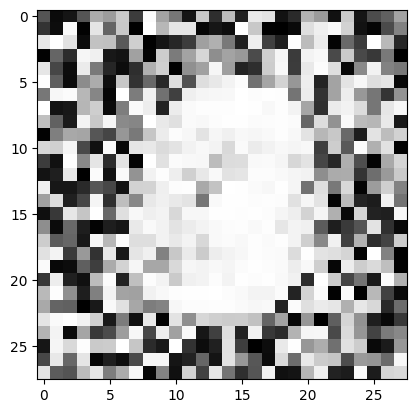

In [132]:
# Sample an image from the generator
z1 = (torch.randn(1, latent_dim)).to(device)

image = generator(z1)[0].cpu()

# Show the image
pixels = image.detach().reshape((28, 28))
plt.imshow(pixels, cmap="gray")
plt.show()